# Simulation Analysis

In [78]:
# Import the libraries used in the notebook
import pandas as pd
from matplotlib import pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import scipy
import time

In [79]:
# The seed for the probabilistic functions
SEED = sum([ord(c) for c in "Social Networks Lab"])

In [80]:
# Read the dataframe with the Possession xG values
xg_df = pd.read_pickle('possession_xGs.pkl')

In [81]:
# Exact distribution
N = 11
bin_coeff = [1, 11, 55, 165, 330, 462, 462, 330, 165, 55, 11, 1]
p_is = [(1/8)] * N
reference_dist = [b*(7/8)**(N-i)*(1/8)**(i) for i, b in enumerate(bin_coeff)]

In [82]:
# The simulation algorithm
def simulation(p_is, n):
    amnts = [0]*(len(p_is)+1)
    for i in range(n):
        goal_amnt = 0
        for j, p_i in enumerate(p_is):
            # random.seed(SEED+(i+1)*(j+1))
            u = random.random()
            if u < p_i:
                goal_amnt +=1
        amnts[goal_amnt] += 1
    return [amnt/n for amnt in amnts]

# The DP algorithm
def dp(p_is):
    n = len(p_is)
    p_k = [1] + [0]*n
    # Iterate over the dp table
    for i in range(n+1):
        for c in range(i, 0, -1):
            inc = p_is[i-1]*p_k[c-1]
            p_k[c-1] -= inc
            p_k[c] += inc
    return p_k

# The FFT algorithm
from poibin.poibin import PoiBin

def fft(p_is):
    return PoiBin(p_is).get_pmf_xi()

In [83]:
# measure how many iterations can be done with the simulation-based
# algorithm in the execution time of one deterministic algorithm
REPEAT = 5000
average_det_exec_times = []
for _ in range(N):
    start = time.perf_counter_ns()
    dp(p_is)
    fft(p_is)
    stop = time.perf_counter_ns()
    average_det_exec_times.append((stop-start)/2)
exec_time_det_algs_microseconds = np.median(average_det_exec_times)/10e3
print(f'Median average execution time for the deterministic algorithms is {exec_time_det_algs_microseconds}µs')

Median average execution time for the deterministic algorithms is 34.25665µs


In [84]:
REPEAT = 1000
SIM_MAX = 500
median_sim_exec_times = []
match_simulations = []
for s in tqdm(range(1, SIM_MAX+1)):
    match_simulations.append(s)
    exec_time_agg = []
    for _ in range(REPEAT):
        start = time.perf_counter_ns()
        simulation(p_is, s)
        stop = time.perf_counter_ns()
        exec_time_agg.append(stop-start)
    median_sim_exec_times.append(np.median(exec_time_agg)/10e3)

100%|██████████| 500/500 [05:25<00:00,  1.53it/s]


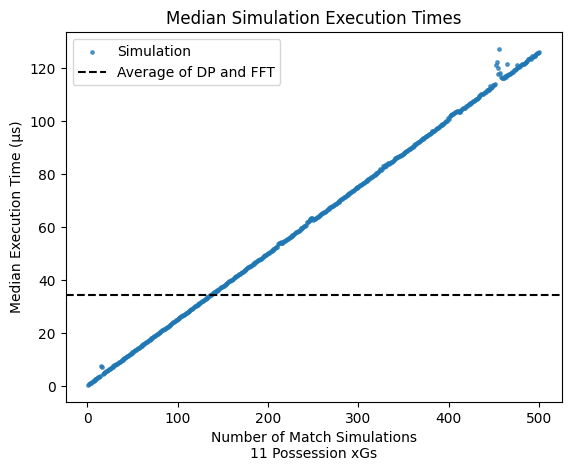

In [85]:
plt.scatter(match_simulations, median_sim_exec_times, s=6, alpha=0.7, label='Simulation')
plt.title('Median Simulation Execution Times')
plt.xlabel('Number of Match Simulations\n11 Possession xGs')
plt.ylabel('Median Execution Time (µs)')
plt.axhline(exec_time_det_algs_microseconds, linestyle='--', c='black', label='Average of DP and FFT')
plt.legend()
plt.show()

In [86]:
one_sim = median_sim_exec_times[0]
last_sim_amnt = median_sim_exec_times[-1]
print(f'Median Execution Time 1 match simulation: {one_sim}µs')
print(f'Median Execution Time {SIM_MAX} match simulation: {last_sim_amnt}µs')

Median Execution Time 1 match simulation: 0.5073µs
Median Execution Time 500 match simulation: 126.1141µs


In [87]:
# Calculate the interception point
slope = (last_sim_amnt-one_sim)/(SIM_MAX-1)
slope_intercept = last_sim_amnt - slope*SIM_MAX
intersection_point = (exec_time_det_algs_microseconds-slope_intercept)/slope
print(f'Point at which Simulation becomes slower: {intersection_point} Match Simulations')

Point at which Simulation becomes slower: 135.0765440246866 Match Simulations


In [88]:
# Redefine the simulation algorithm with fixed seed
def simulation(p_is, n):
    amnts = [0]*(len(p_is)+1)
    for i in range(n):
        goal_amnt = 0
        for j, p_i in enumerate(p_is):
            random.seed(SEED+(i+1)*(j+1))
            u = random.random()
            if u < p_i:
                goal_amnt +=1
        amnts[goal_amnt] += 1
    return [amnt/n for amnt in amnts]

In [89]:
SIMULATIONS = 1000
match_simulations = []
cosine_differences = []
max_abs_differences = []
for s in tqdm(range(1, SIMULATIONS+1)):
    simulated_dist = simulation(p_is, s)
    max_abs_differences.append(max([abs(simulated_entry - ref_entry) for simulated_entry, ref_entry in zip(simulated_dist, reference_dist)]))
    cosine_differences.append(scipy.spatial.distance.cosine(reference_dist, simulated_dist))
    match_simulations.append(s)

100%|██████████| 1000/1000 [01:11<00:00, 14.04it/s]


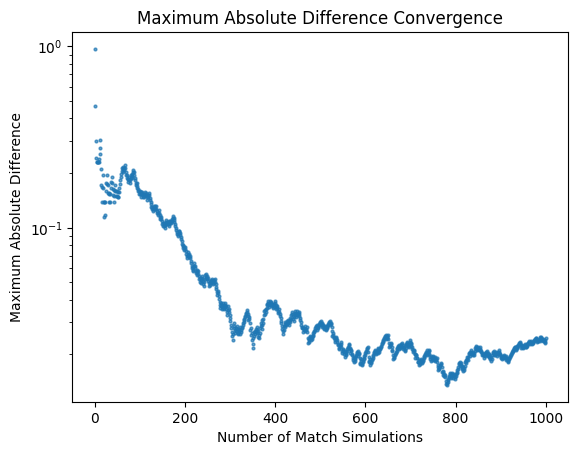

In [90]:
plt.clf()
plt.scatter(match_simulations, max_abs_differences, alpha=0.7, s=4)
plt.yscale('log')
plt.title('Maximum Absolute Difference Convergence')
plt.xlabel('Number of Match Simulations')
plt.ylabel('Maximum Absolute Difference')
plt.show()

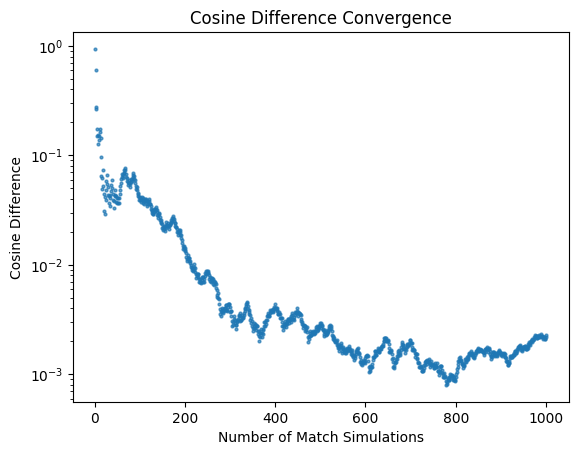

In [91]:
plt.clf()
plt.scatter(match_simulations, cosine_differences, alpha=0.7, s=4)
plt.yscale('log')
plt.title('Cosine Difference Convergence')
plt.xlabel('Number of Match Simulations')
plt.ylabel('Cosine Difference')
plt.show()